In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
 
# ../input/cifar10-python
 
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# load cifar10 data 
path = "D:/BaiduNetdiskDownload/data/"
train_data = torchvision.datasets.CIFAR10(root=path, train=True, transform=torchvision.transforms.Compose(
    [torchvision.transforms.ColorJitter(0.5), torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.CIFAR10(root=path, train=False, transform=torchvision.transforms.ToTensor())
 
train_dataloader = DataLoader(train_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)
# print(len(train_dataloader)) #781
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
test_data_size = len(test_data)
train_data_size = len(train_data)
print(f'测试集大小为：{test_data_size}')
print(f'训练集大小为：{train_data_size}')
writer = SummaryWriter("./model_logs")
 
loss_fn = nn.CrossEntropyLoss(reduction='mean')
loss_fn = loss_fn.to(device)
time_able = True  # True
 
 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
 
 
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
 
 
 
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = conv_block(3, 32)   # 3,32,32
        self.conv2 = conv_block(32, 64, pool=True)  # 64,16,16
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))  # 64, 16, 16
        self.conv3 = conv_block(64, 128)  # 128, 16, 16
        self.conv4 = conv_block(128, 256,pool=True)  # 256, 8, 8
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))  # 256,8,8
        self.conv5 = conv_block(256, 512)  # 512, 8, 8
        self.conv6 = conv_block(512, 1024, pool=True)  # 1024, 4, 4
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))  # 1024, 4, 4
        self.linear1 = nn.Sequential(nn.MaxPool2d(4),  #1024,1,1
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(1024, 10))
 
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.linear1(out)
        return out
 
 
 
model = Model()
model = model.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
epoch = 11
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))
running_loss = 0
total_train_step = 0
total_test_step = 0
if time_able:
    str_time = time.time()
for i in range(epoch):
    
    print(f'第{i + 1}次epoch')
    model.train()
    lrs = []
    total_accuracy1 = 0
    for data in train_dataloader:
        imgs, targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        lrs.append(get_lr(optimizer))
        total_train_step += 1
        if total_train_step % 200 == 0:
            if time_able:
                end_time = time.time()
                print(f'{end_time - str_time}')
            print(f'第{total_train_step}次训练，loss = {loss.item()},lr_last = {lrs[-1]}')
            writer.add_scalar("train_loss", loss.item(), total_train_step)
        accuracy1 = (output.argmax(1) == targets).sum()
        total_accuracy1 += accuracy1
 
    # 测试
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss = total_test_loss + loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    total_test_loss = total_test_loss / test_data_size
    print(f'整体测试集上的loss = {total_test_loss}')
    print(f'整体测试集正确率 = {total_accuracy / test_data_size}')
    print(f'整体训练集正确率 = {total_accuracy1 / train_data_size}')
    writer.add_scalar("test_loss", total_test_loss.item(), total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy / test_data_size, total_test_step)
    writer.add_scalar("train_accuracy", total_accuracy1 / train_data_size, total_test_step)  # test_step == epoch
    total_test_step += 1
 


测试集大小为：10000
训练集大小为：50000
第1次epoch
27.50791358947754
第200次训练，loss = 1.2241061925888062,lr_last = 0.0009587927472379
整体测试集上的loss = 0.016328115016222
整体测试集正确率 = 0.4729999899864197
整体训练集正确率 = 0.4401399791240692
第2次epoch
52.941730260849
第400次训练，loss = 1.2226333618164062,lr_last = 0.002505067099632564
76.06199550628662
第600次训练，loss = 1.1024154424667358,lr_last = 0.004678803518284779
整体测试集上的loss = 0.009289958514273167
整体测试集正确率 = 0.5985000133514404
整体训练集正确率 = 0.6182399988174438
第3次epoch
102.93015599250793
第800次训练，loss = 0.8508533239364624,lr_last = 0.006973890276048818
126.84822368621826
第1000次训练，loss = 0.8011865615844727,lr_last = 0.008855961608541227
整体测试集上的loss = 0.3507828414440155
整体测试集正确率 = 0.1979999989271164
整体训练集正确率 = 0.6862399578094482
第4次epoch
154.2055847644806
第1200次训练，loss = 1.4218814373016357,lr_last = 0.009886814261436531
178.3939492702484
第1400次训练，loss = 0.5959793925285339,lr_last = 0.009966679206643986
整体测试集上的loss = 0.005491382442414761
整体测试集正确率 = 0.7631999850273132
整体训练集正确率 = 

In [4]:
from tensorboardX import SummaryWriter
from torchsummary import summary

print(model)
summary(model, (3, 32, 32))



Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )


In [6]:
# save graph 
 
dummy_input01 = torch.rand(10, 3, 32, 32)  # 假设输入10张1*28*28的图片
dummy_input01 = dummy_input01.to(device)

writer.add_graph(model, dummy_input01)
writer.close()

In [7]:
# save model 

PATH = './model/cifar_net.pth'
torch.save(model.state_dict(), PATH)


In [30]:
# 学习测试集合

t = test_dataloader
t1 = train_dataloader
print(len(t)  , len(t1))

## 访问数据
d = next(iter(t))
print(len(d),d[0].shape , d[1].shape)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


images, labels = d[0] , d[1]

79 391
2 torch.Size([128, 3, 32, 32]) torch.Size([128])


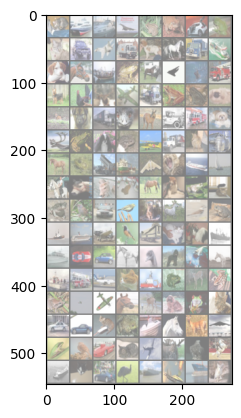

  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat


In [33]:
# 绘图
import matplotlib.pyplot as plt
import numpy as np
## 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
## 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [37]:
# 评估
def eval_model(model , device , data ):
    model.eval()

    if(device):
        data = data.to(device)
    
    outputs = model(data)
    return outputs 
    
outputs = eval_model(model,device,images )    
_, predicted = torch.max(outputs.data, 1)
print(_.shape , predicted.shape )
print(_)
print(predicted)

torch.Size([128]) torch.Size([128])
tensor([ 9.4478, 12.0536,  7.5359,  4.8840, 14.4752,  8.4669, 11.2711,  7.9170,
        10.3638,  9.1810,  7.1699, 18.0386,  7.0828, 16.2337, 11.6053,  3.1992,
         9.4523, 13.3048, 11.1993, 17.3003,  5.6655,  9.3063,  6.1353, 16.1856,
        10.2421,  5.1324,  6.8833,  7.6767,  7.9068,  8.3377,  5.1426, 16.0306,
         3.8468,  5.5991, 17.6132,  6.5992, 19.1102,  6.9704, 16.6625, 15.7131,
        12.7406, 13.0305,  6.6140, 14.1252, 10.7238, 19.7551,  8.0091,  3.5323,
        25.7272,  8.0585,  9.5916,  9.4594,  3.1105,  5.0009, 13.5112, 15.2117,
         7.2145, 10.3642,  6.5054,  3.7693, 24.2806,  5.9939,  7.6209,  5.6512,
        11.0129,  9.8990,  6.7129,  9.8223,  3.3835, 12.8016,  2.4625, 13.6489,
        13.8432, 14.9690,  6.5033, 15.6816,  8.4860,  9.1089,  4.1867, 14.2699,
        13.8793,  6.8721, 16.9811,  8.0685,  8.5296,  2.8418,  4.5712,  7.9554,
        13.0981, 11.2624, 14.3035,  6.7385, 11.7333, 16.1116, 10.6402,  6.2469,
    